In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.image as mpimg
import os
import cv2
from tensorflow.keras.utils import Sequence
%matplotlib inline

In [10]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [93]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    print(indices)

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(img,(256,256))
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(img2,(256,256))
#       print(img_path,img_path2)

      X[i,] = img
      Y[i,] = img2

    return X, Y

In [98]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img.astype(np.uint8)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [94]:
train = DataGenerator('data/train_x/train_x','data/train_y/train_y',(256, 256), batch_size=10, shuffle=False)
test  = DataGenerator('data/test_x/test_x','data/test_y/test_y',(256, 256), batch_size=10, shuffle=False)

[540 541 542 543 544 545 546 547 548 549]
data/train_x/train_x\image10483.jpg data/train_y/train_y\image10483.jpg
data/train_x/train_x\image10484.jpg data/train_y/train_y\image10484.jpg
data/train_x/train_x\image10485.jpg data/train_y/train_y\image10485.jpg
data/train_x/train_x\image10486.jpg data/train_y/train_y\image10486.jpg
data/train_x/train_x\image10487.jpg data/train_y/train_y\image10487.jpg
data/train_x/train_x\image10488.jpg data/train_y/train_y\image10488.jpg
data/train_x/train_x\image10489.jpg data/train_y/train_y\image10489.jpg
data/train_x/train_x\image1049.jpg data/train_y/train_y\image1049.jpg
data/train_x/train_x\image10490.jpg data/train_y/train_y\image10490.jpg
data/train_x/train_x\image10491.jpg data/train_y/train_y\image10491.jpg


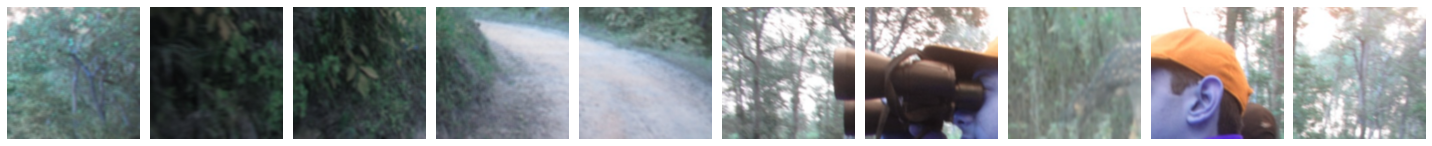

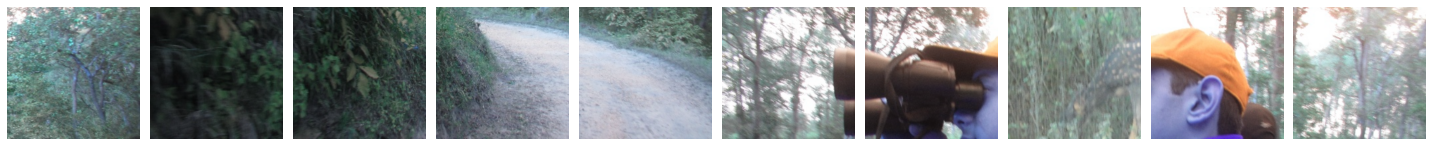

In [101]:
xx,yy=train[54]
plotImages(xx)
plotImages(yy)

In [97]:
# train_x = ImageDataGenerator().flow_from_directory(directory='data/train_x',target_size=(256,256),batch_size=10,shuffle=False)
# train_y = ImageDataGenerator().flow_from_directory(directory='data/train_y',target_size=(256,256),batch_size=10,shuffle=False)
# test_x  = ImageDataGenerator().flow_from_directory(directory='data/test_x' ,target_size=(256,256),batch_size=10,shuffle=False)
# test_y  = ImageDataGenerator().flow_from_directory(directory='data/test_y' ,target_size=(256,256),batch_size=10,shuffle=False)

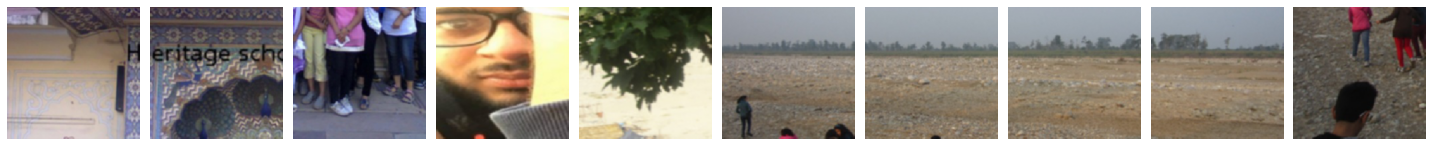

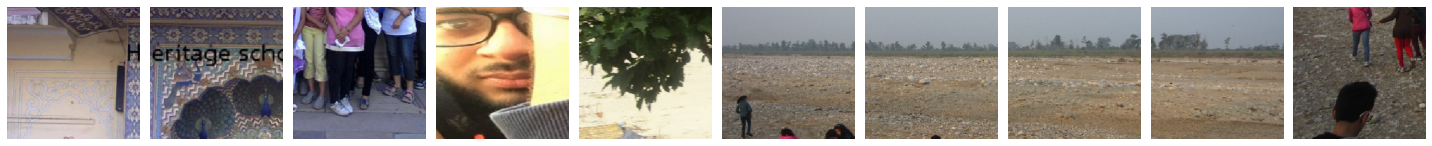

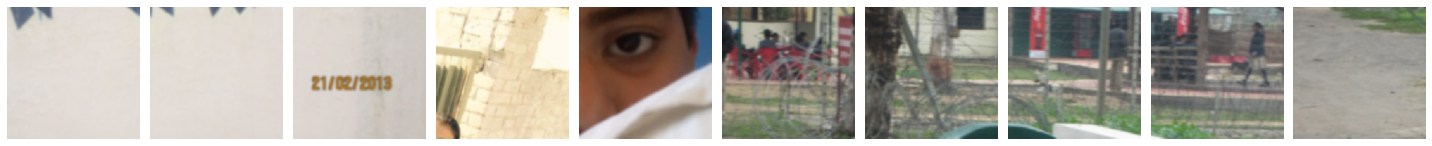

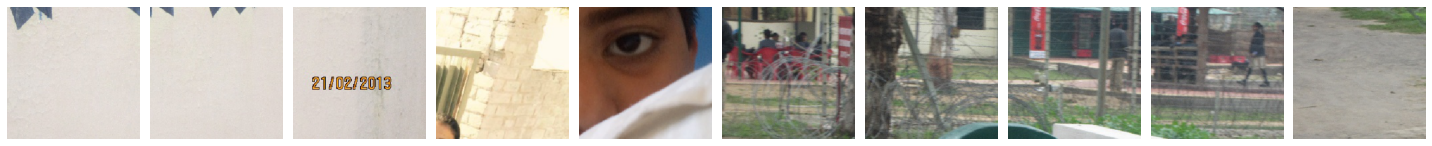

In [5]:
# imgs1,_=next(train_x)
# imgs2,_=next(train_y)
# imgs3,_=next(test_x)
# imgs4,_=next(test_y)
# plotImages(imgs1)
# plotImages(imgs2)
# plotImages(imgs3)
# plotImages(imgs4)

In [6]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(256,256,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 32, 3)
   conv_block2 = conv_operation(conv_block1, 64, 3)
   conv_block3 = conv_operation(conv_block2, 128, 3)
   conv_block4 = conv_operation(conv_block3, 256, 3)
   
   conv_block5 = conv_operation(conv_block4, 256, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 256,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, dae_outputs, name='dae')

In [7]:
model= deblurring_autoencoder()

In [8]:
model.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         dae_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [9]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae","acc"])

In [12]:
callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    ModelCheckpoint('deblur_my_shit.h5',verbose=1,save_best_only=True,save_weights_only=True)
]

In [15]:
model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    epochs=300,
    callbacks=callbacks
)

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.